##SE 495: Emerging Topics in Software Engineering
##Milestone Project: AI for Cybersecurity
##Monitoring and detecting cyberattacks based on traffic data and DNS information#

## Step 1: Data Preparation & Exploration

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
# Load the combined dataset
df = pd.read_csv("/content/combined_dataset.csv")

# Data Exploration
print("Dataset Shape:", df.shape)
print("\nAttack Type Distribution:")
print(df['attack_type'].value_counts())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (130502, 17)

Attack Type Distribution:
attack_type
botnet    130383
normal       118
Name: count, dtype: int64

Missing Values:
StartTime           0
Dur                 1
Proto               1
SrcAddr             1
Sport              14
Dir                 1
DstAddr             1
Dport              18
State               1
sTos               14
dTos              140
TotPkts             1
TotBytes            1
SrcBytes            1
Label               1
attack_type         1
SrcPkts        130502
dtype: int64


<ipython-input-4-50314e88e775>:2: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/combined_dataset.csv")


In [ ]:
# Data Preprocessing
# Convert timestamps to datetime and extract features
if 'StartTime' in df.columns:
    df['StartTime'] = pd.to_datetime(df['StartTime'], errors='coerce')
    df['hour'] = df['StartTime'].dt.hour
    df['day_of_week'] = df['StartTime'].dt.dayofweek
    df['is_weekend'] = df['StartTime'].dt.dayofweek.isin([5, 6]).astype(int)

In [ ]:
# Feature Engineering
# Convert categorical features to numerical
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'attack_type' and col != 'Label']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Convert duration and other features to numeric
if 'Dur' in df.columns:
    df['Dur'] = pd.to_numeric(df['Dur'], errors='coerce')
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

In [ ]:
# Handle missing values
# Identify numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
non_numeric_cols = df.select_dtypes(exclude=['number']).columns

# Handle missing values in numeric columns with median
if not numeric_cols.empty:
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Handle missing values in non-numeric columns with most frequent value
if not non_numeric_cols.empty:
    for col in non_numeric_cols:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else "Unknown")

print(f"Filled missing values in {len(numeric_cols)} numeric columns and {len(non_numeric_cols)} non-numeric columns")

Filled missing values in 17 numeric columns and 3 non-numeric columns


In [ ]:
# Feature Selection
# Drop redundant or irrelevant columns
cols_to_drop = ['Label']  # Add any other columns you want to drop
df_processed = df.drop(columns=cols_to_drop, errors='ignore')

# Split features and target
X = df_processed.drop(columns=['attack_type'], errors='ignore')
y = df_processed['attack_type']

# Create a binary classification target (malicious vs normal)
y_binary = y.apply(lambda x: 'normal' if x == 'normal' else 'malicious')

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.3, random_state=42)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Convert X_train and X_test back to DataFrames
if not isinstance(X_train, pd.DataFrame):
    try:
        X_train = pd.DataFrame(X_train, columns=feature_names)
        X_test = pd.DataFrame(X_test, columns=feature_names)
    except:
        print("Warning: Converting to DataFrame without column names")
        X_train = pd.DataFrame(X_train)
        X_test = pd.DataFrame(X_test)

# Identify datetime columns
datetime_cols = X_train.select_dtypes(include=['datetime64']).columns

# Convert datetime columns to numeric features (timestamp or extracted features)
for col in datetime_cols:
    # Convert to Unix timestamp (seconds since epoch)
    X_train[f"{col}_timestamp"] = X_train[col].astype(np.int64) // 10**9
    X_test[f"{col}_timestamp"] = X_test[col].astype(np.int64) // 10**9

    # Optionally extract more features like hour, day, etc.
    X_train[f"{col}_hour"] = X_train[col].dt.hour
    X_test[f"{col}_hour"] = X_test[col].dt.hour

    # Drop the original datetime column
    X_train = X_train.drop(columns=[col])
    X_test = X_test.drop(columns=[col])

# Verify all columns are now numeric
print("Data types after datetime conversion:")
print(X_train.dtypes.value_counts())

# Now apply scaling to the numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Data types after datetime conversion:
int64      9
float64    7
int32      3
Name: count, dtype: int64
X_train_scaled shape: (91351, 19)
X_test_scaled shape: (39151, 19)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
# Save column names for later use
feature_names = X.columns

In [ ]:
# Create DataFrames without specifying column names
X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_test_scaled_df = pd.DataFrame(X_test_scaled)

print(f"X_train_scaled_df shape: {X_train_scaled_df.shape}")
print(f"X_test_scaled_df shape: {X_test_scaled_df.shape}")

# Save processed data
df_processed.to_csv("processed_dataset.csv", index=False)

X_train_scaled_df shape: (91351, 19)
X_test_scaled_df shape: (39151, 19)


## Step 2: Binary Classification (Malicious vs. Normal)

In [ ]:
# Import Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
# Function to evaluate and compare models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    f1_macro = f1_score(y_test, y_pred, average='macro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')

    # Print results
    print(f"\n--- {model_name} Performance ---")
    print(f"Weighted F1-Score: {f1:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    return {
        'model': model,
        'predictions': y_pred,
        'f1_weighted': f1,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_macro': f1_macro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'confusion_matrix': cm
    }

print("\n===== BINARY CLASSIFICATION =====")
print("Detecting Malicious vs. Normal Traffic")


===== BINARY CLASSIFICATION =====
Detecting Malicious vs. Normal Traffic


In [ ]:
# Define models for binary classification
binary_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,50), max_iter=300, random_state=42)
}

In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# Check for NaN values in scaled data
print(f"NaN values in X_train_scaled: {np.isnan(X_train_scaled).sum()}")
print(f"NaN values in X_test_scaled: {np.isnan(X_test_scaled).sum()}")

# Create an imputer
imputer = SimpleImputer(strategy='mean')

# Apply imputation to handle NaN values
X_train_scaled_fixed = imputer.fit_transform(X_train_scaled)
X_test_scaled_fixed = imputer.transform(X_test_scaled)

# Verify no NaNs remain
print(f"NaN values after imputation in X_train_scaled_fixed: {np.isnan(X_train_scaled_fixed).sum()}")
print(f"NaN values after imputation in X_test_scaled_fixed: {np.isnan(X_test_scaled_fixed).sum()}")

# Replace the original variables for use in subsequent steps
X_train_scaled = X_train_scaled_fixed
X_test_scaled = X_test_scaled_fixed

# Continue with model evaluation
print("Data is now ready for model evaluation")

NaN values in X_train_scaled: 91351
NaN values in X_test_scaled: 39151
NaN values after imputation in X_train_scaled_fixed: 0
NaN values after imputation in X_test_scaled_fixed: 0
Data is now ready for model evaluation


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [ ]:
# Evaluate each model for binary classification
binary_results = {}
for name, model in binary_models.items():
    binary_results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_bin, y_test_bin, name)

# Find the best model for binary classification
best_binary_model_name = max(binary_results, key=lambda k: binary_results[k]['f1_weighted'])
print(f"\nBest Binary Classification Model: {best_binary_model_name}")
print(f"F1-Score (Weighted): {binary_results[best_binary_model_name]['f1_weighted']:.4f}")
print(f"F1-Score (Macro): {binary_results[best_binary_model_name]['f1_macro']:.4f}")


--- Logistic Regression Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 0.9937
Macro Precision: 1.0000
Macro Recall: 0.9875

--- Random Forest Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000

--- Gradient Boosting Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000

--- SVM Performance ---
Weighted F1-Score: 0.9999
Weighted Precision: 0.9999
Weighted Recall: 0.9999
Macro F1-Score: 0.9737
Macro Precision: 0.9999
Macro Recall: 0.9500

--- Neural Network Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 0.9937
Macro Precision: 1.0000
Macro Recall: 0.9875

Best Binary Classification Model: Random Forest
F1-Score (Weighted): 1.0000
F1-Score (Macro): 1.00

## Step 3: Multi-class Classification (Botnet, DDoS, Normal)

In [ ]:
# Define models for multi-class classification
multiclass_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(kernel='rbf', random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100,50), max_iter=300, random_state=42)
}

In [ ]:
# Evaluate each model for multi-class classification
multiclass_results = {}
for name, model in multiclass_models.items():
    multiclass_results[name] = evaluate_model(model, X_train_scaled, X_test_scaled, y_train, y_test, name)

# Find the best model for multi-class classification
best_multiclass_model_name = max(multiclass_results, key=lambda k: multiclass_results[k]['f1_weighted'])
print(f"\nBest Multi-class Classification Model: {best_multiclass_model_name}")
print(f"F1-Score (Weighted): {multiclass_results[best_multiclass_model_name]['f1_weighted']:.4f}")
print(f"F1-Score (Macro): {multiclass_results[best_multiclass_model_name]['f1_macro']:.4f}")


--- Logistic Regression Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 0.9937
Macro Precision: 1.0000
Macro Recall: 0.9875

--- Random Forest Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000

--- Gradient Boosting Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000

--- SVM Performance ---
Weighted F1-Score: 0.9999
Weighted Precision: 0.9999
Weighted Recall: 0.9999
Macro F1-Score: 0.9737
Macro Precision: 0.9999
Macro Recall: 0.9500

--- Neural Network Performance ---
Weighted F1-Score: 1.0000
Weighted Precision: 1.0000
Weighted Recall: 1.0000
Macro F1-Score: 0.9937
Macro Precision: 1.0000
Macro Recall: 0.9875

Best Multi-class Classification Model: Random Forest
F1-Score (Weighted): 1.0000
F1-Score (Macro):

## Step 4: Feature Importance Analysis

In [ ]:
def plot_feature_importance(model, feature_names, title):
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For linear models
        importances = np.abs(model.coef_).mean(axis=0) if model.coef_.ndim > 1 else np.abs(model.coef_)
    else:
        print(f"Cannot extract feature importance from {title}")
        return

    # Create dataframe for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })

    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False).head(15)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title(f'Top 15 Feature Importance - {title}')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{title.replace(" ", "_").lower()}.png')
    plt.close()

In [ ]:
# Plot feature importance for the best binary model
best_binary_model = binary_results[best_binary_model_name]['model']
try:
    plot_feature_importance(best_binary_model, feature_names, 'Binary Classification')
except:
    print("Could not plot feature importance for binary model")

In [ ]:
# Plot feature importance for the best multiclass model
best_multiclass_model = multiclass_results[best_multiclass_model_name]['model']
try:
    plot_feature_importance(best_multiclass_model, feature_names, 'Multi-class Classification')
except:
    print("Could not plot feature importance for multiclass model")

## Step 5: Advanced Model - Deep Learning

In [ ]:
# Deep Learning Model Setup and Training
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    from tensorflow.keras.utils import to_categorical
    from sklearn.preprocessing import LabelEncoder

    print("\n===== DEEP LEARNING MODEL =====")

    # Encode target variables
    le_multi = LabelEncoder()
    y_train_encoded = le_multi.fit_transform(y_train)
    y_test_encoded = le_multi.transform(y_test)

    # Convert to categorical for multi-class
    y_train_cat = to_categorical(y_train_encoded)
    y_test_cat = to_categorical(y_test_encoded)

    # Build model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(len(le_multi.classes_), activation='softmax')
    ])

    # Compile model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

except ImportError:
    print("TensorFlow not available. Skipping deep learning model.")
except Exception as e:
    print(f"Error in deep learning model setup: {e}")


===== DEEP LEARNING MODEL =====


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Model Training
try:
    # Train model
    history = model.fit(
        X_train_scaled, y_train_cat,
        epochs=30,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )
except NameError:
    print("Deep learning model not defined. Skipping training.")
except Exception as e:
    print(f"Error in model training: {e}")

Epoch 1/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9939 - loss: 0.0365 - val_accuracy: 0.9999 - val_loss: 0.0099
Epoch 2/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9999 - loss: 0.0029 - val_accuracy: 0.9999 - val_loss: 0.0022
Epoch 3/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9999 - loss: 5.3809e-04 - val_accuracy: 0.9999 - val_loss: 0.0020
Epoch 4/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.0000 - loss: 4.5230e-04 - val_accuracy: 0.9999 - val_loss: 0.0019
Epoch 5/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 1.0000 - loss: 1.4811e-04 - val_accuracy: 0.9999 - val_loss: 0.0029
Epoch 6/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 1.0000 - loss: 6.6735e-05 - val_accuracy: 0.9999 - val_loss: 0.0031
Epoch 7/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 1.0000 - loss: 6.4603e-05 - val_accuracy: 0.9999 - val_loss: 0.0034
Epoch 8/30
1142/1142 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 1.00

In [ ]:
# Model Evaluation
try:
    # Evaluate model
    y_pred_prob = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)
    y_test_classes = np.argmax(y_test_cat, axis=1)

    # Calculate metrics
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')

    f1_macro = f1_score(y_test_classes, y_pred_classes, average='macro')
    precision_macro = precision_score(y_test_classes, y_pred_classes, average='macro')
    recall_macro = recall_score(y_test_classes, y_pred_classes, average='macro')

    print("\n--- Deep Learning Model Performance ---")
    print(f"Weighted F1-Score: {f1:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Macro F1-Score: {f1_macro:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
except NameError:
    print("Deep learning model not trained. Skipping evaluation.")
except Exception as e:
    print(f"Error in model evaluation: {e}")

1224/1224 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

--- Deep Learning Model Performance ---
Weighted F1-Score: 0.9999
Weighted Precision: 0.9999
Weighted Recall: 0.9999
Macro F1-Score: 0.9756
Macro Precision: 0.9643
Macro Recall: 0.9875


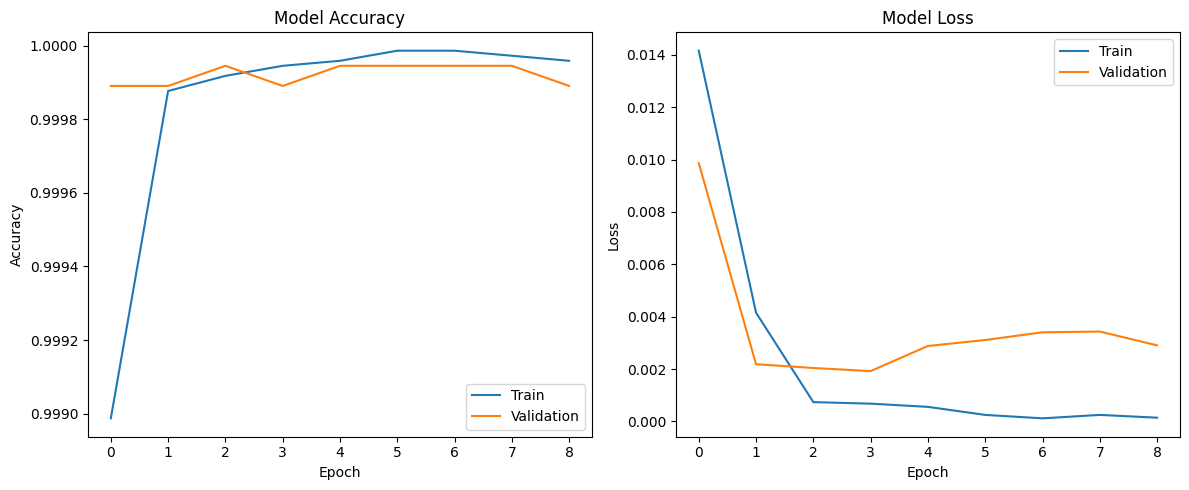

Deep Learning model saved to 'deep_learning_model.h5'


In [ ]:
# Visualize Training History
try:
    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig('deep_learning_training_history.png')
    plt.show()

    # Save the model
    model.save('deep_learning_model.h5')
    print("Deep Learning model saved to 'deep_learning_model.h5'")
except NameError:
    print("Training history not available. Skipping visualization.")
except Exception as e:
    print(f"Error in history visualization: {e}")

## Step 6: Dashboard & Visualization (for Task II)

In [ ]:
# Create Visualization Function
def create_visualizations():
    # 1. Attack Distribution Pie Chart
    plt.figure(figsize=(10, 6))
    attack_counts = df['attack_type'].value_counts()
    plt.pie(attack_counts, labels=attack_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Distribution of Attack Types')
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig('attack_distribution.png')
    plt.show()

    # 2. Traffic Volume by Time
    if 'StartTime' in df.columns and 'hour' in df.columns:
        plt.figure(figsize=(12, 6))
        df_hourly = df.groupby(['hour', 'attack_type']).size().unstack().fillna(0)
        df_hourly.plot(kind='bar', stacked=True)
        plt.title('Traffic Volume by Hour of Day')
        plt.xlabel('Hour')
        plt.ylabel('Number of Traffic Records')
        plt.legend(title='Attack Type')
        plt.tight_layout()
        plt.savefig('traffic_by_hour.png')
        plt.show()

    # 3. Feature Correlation Heatmap
    plt.figure(figsize=(12, 10))
    corr_matrix = df_processed.select_dtypes(include=['float64', 'int64']).corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=False, mask=mask, cmap='coolwarm', linewidths=0.5)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()

    # 4. Confusion Matrix Visualization
    plt.figure(figsize=(10, 8))
    cm = multiclass_results[best_multiclass_model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f'Confusion Matrix - {best_multiclass_model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

    # 5. Model Comparison Bar Chart
    plt.figure(figsize=(12, 6))
    model_names = list(multiclass_results.keys())
    f1_scores_weighted = [multiclass_results[name]['f1_weighted'] for name in model_names]
    f1_scores_macro = [multiclass_results[name]['f1_macro'] for name in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    plt.bar(x - width/2, f1_scores_weighted, width, label='Weighted F1')
    plt.bar(x + width/2, f1_scores_macro, width, label='Macro F1')

    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.title('Model Performance Comparison')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

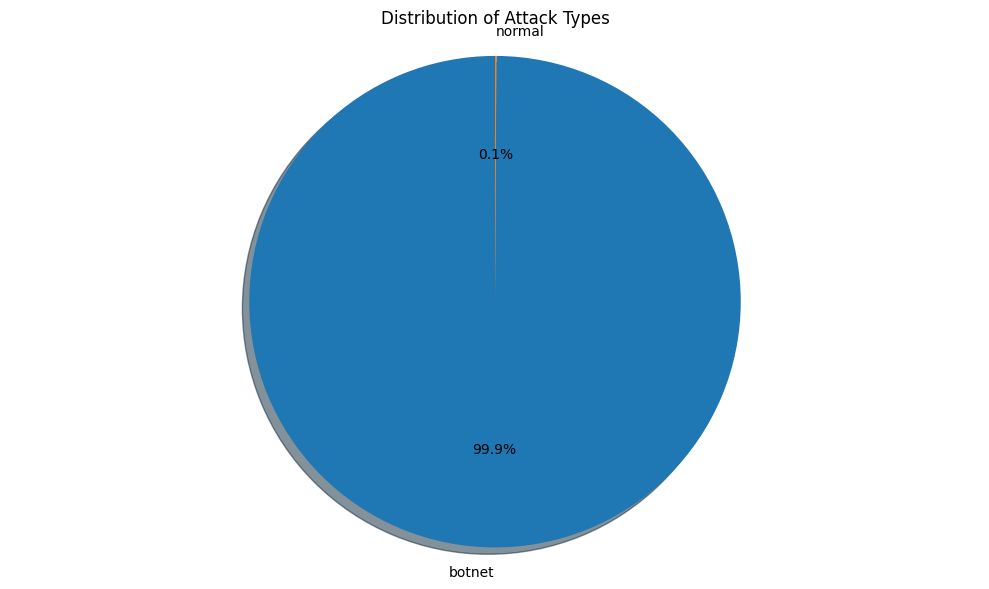

<Figure size 1200x600 with 0 Axes>

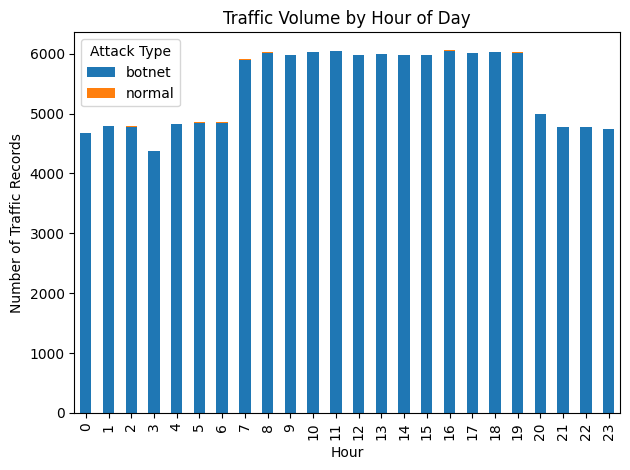

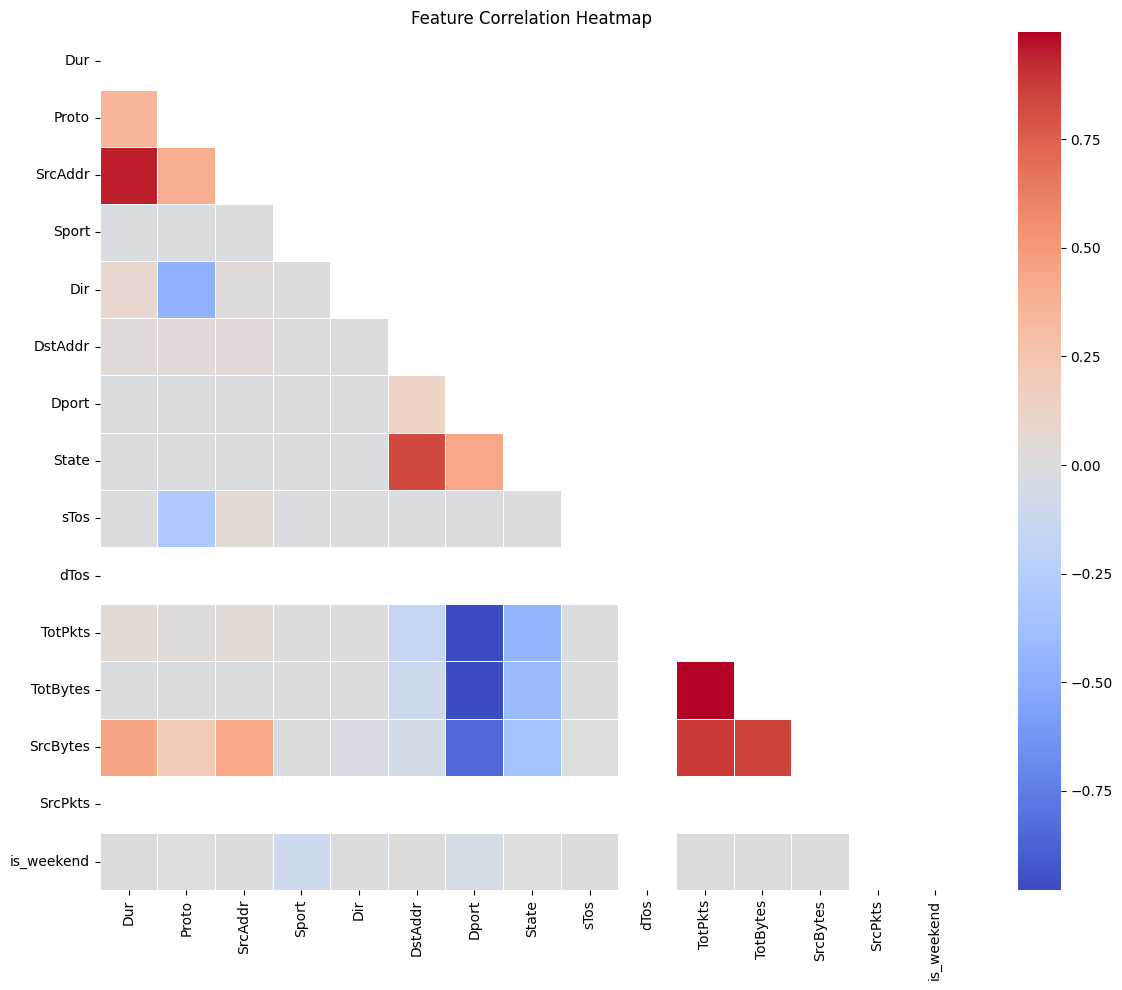

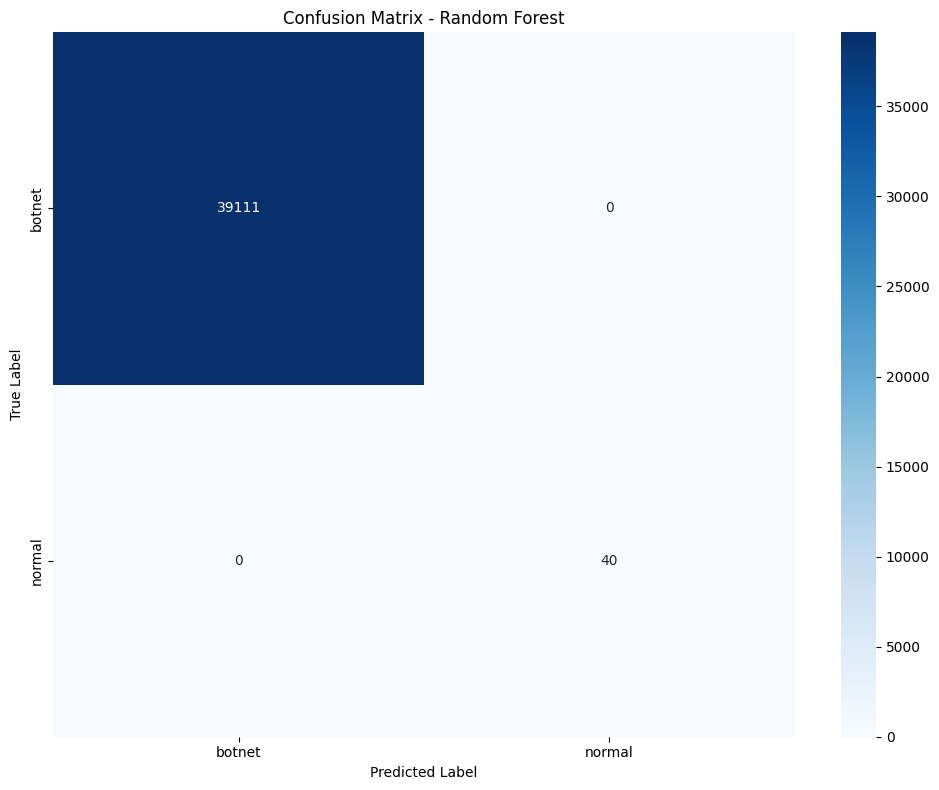

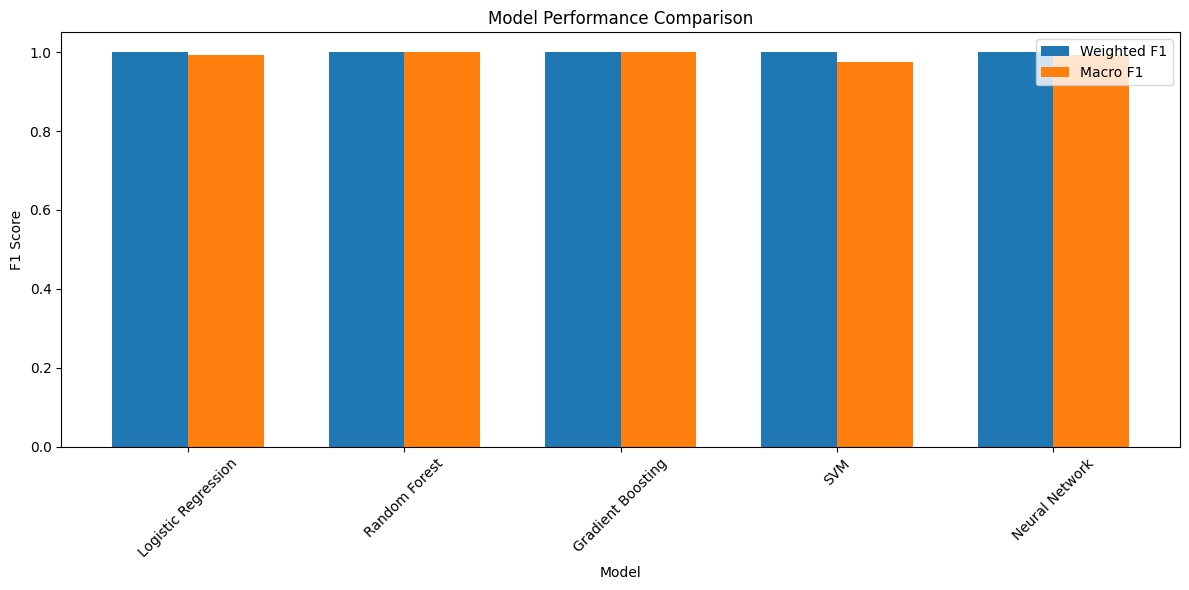

In [ ]:
# Create Visualizations
# Run all the visualization functions
create_visualizations()

In [ ]:
# Create an HTML dashboard
dashboard_html = """
<!DOCTYPE html>
<html>
<head>
    <title>Cybersecurity ML Dashboard</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 20px;
            background-color: #f5f5f5;
            color: #333;
        }
        h1, h2 {
            color: #333;
        }
        .container {
            display: flex;
            flex-wrap: wrap;
            justify-content: space-around;
        }
        .card {
            background-color: white;
            border-radius: 8px;
            box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);
            margin: 15px;
            padding: 20px;
            width: calc(50% - 70px);
        }
        .full-width {
            width: calc(100% - 70px);
        }
        .card h2 {
            border-bottom: 1px solid #ccc;
            padding-bottom: 10px;
            color: #333;
        }
        img {
            max-width: 100%;
            height: auto;
            display: block;
            margin: 0 auto;
            border: 1px solid #ddd;
            background-color: #f8f8f8;
            padding: 5px;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            margin-top: 15px;
            border: 2px solid #ddd;
        }
        th, td {
            padding: 12px;
            text-align: left;
            border-bottom: 1px solid #aaa;
            border-right: 1px solid #aaa;
        }
        th {
            background-color: #445566;
            color: white;
            font-weight: bold;
        }
        tr:nth-child(even) {
            background-color: #f2f2f2;
        }
        tr:nth-child(odd) {
            background-color: #e6e6e6;
        }
        tr:hover {
            background-color: #ddd;
        }
        td {
            color: #333;
        }
        .img-container {
            position: relative;
            width: 100%;
            height: 300px;
            border: 1px dashed #ccc;
            overflow: hidden;
            display: flex;
            align-items: center;
            justify-content: center;
            background-color: #f8f8f8;
            margin-bottom: 10px;
        }
        .img-container img {
            max-width: 100%;
            max-height: 100%;
            object-fit: contain;
            border: none;
            padding: 0;
            background: none;
        }
        .img-placeholder {
            width: 100%;
            height: 300px;
            background-color: #f0f0f0;
            display: flex;
            align-items: center;
            justify-content: center;
            border: 1px dashed #999;
            color: #666;
            font-weight: bold;
            text-align: center;
        }
        .upload-btn {
            display: block;
            width: 100%;
            padding: 10px;
            background-color: #4CAF50;
            color: white;
            border: none;
            border-radius: 4px;
            cursor: pointer;
            text-align: center;
            margin-top: 5px;
        }
        .upload-btn:hover {
            background-color: #45a049;
        }
        .note {
            font-style: italic;
            margin-top: 10px;
            color: #666;
        }
        .card-footer {
            margin-top: 15px;
            border-top: 1px solid #eee;
            padding-top: 10px;
            font-size: 0.9em;
            color: #666;
        }
        .best-model-row {
            font-weight: bold;
            background-color: #e6f7ff;
            border-left: 4px solid #1890ff;
        }
        .best-model-row td {
            color: #000 !important;
        }
    </style>
    <script>
        function handleImageUpload(input, imgId) {
            const file = input.files[0];
            if (file) {
                const reader = new FileReader();
                reader.onload = function(e) {
                    const img = document.getElementById(imgId);
                    img.src = e.target.result;
                    img.style.display = 'block';

                    const placeholder = document.getElementById(imgId + '-placeholder');
                    if (placeholder) {
                        placeholder.style.display = 'none';
                    }
                };
                reader.readAsDataURL(file);
            }
        }
    </script>
</head>
<body>
    <h1>Cybersecurity Traffic Analysis Dashboard</h1>

    <div class="container">
        <div class="card">
            <h2>Attack Type Distribution</h2>
            <div class="img-container">
                <img id="img-attack-distribution" style="display: none;">
                <div id="img-attack-distribution-placeholder" class="img-placeholder">
                    Upload Attack Distribution Image
                </div>
            </div>
            <input type="file" id="upload-attack-distribution" style="display: none;" accept="image/*" onchange="handleImageUpload(this, 'img-attack-distribution')">
            <label for="upload-attack-distribution" class="upload-btn">Upload Image</label>
            <div class="card-footer">
                Shows the distribution of various attack types detected in the network traffic.
            </div>
        </div>

        <div class="card">
            <h2>Traffic by Hour of Day</h2>
            <div class="img-container">
                <img id="img-traffic-by-hour" style="display: none;">
                <div id="img-traffic-by-hour-placeholder" class="img-placeholder">
                    Upload Traffic by Hour Image
                </div>
            </div>
            <input type="file" id="upload-traffic-by-hour" style="display: none;" accept="image/*" onchange="handleImageUpload(this, 'img-traffic-by-hour')">
            <label for="upload-traffic-by-hour" class="upload-btn">Upload Image</label>
            <div class="card-footer">
                Displays network traffic patterns throughout the day, broken down by attack types.
            </div>
        </div>

        <div class="card full-width">
            <h2>Model Performance Comparison</h2>
            <div class="img-container">
                <img id="img-model-comparison" style="display: none;">
                <div id="img-model-comparison-placeholder" class="img-placeholder">
                    Upload Model Comparison Image
                </div>
            </div>
            <input type="file" id="upload-model-comparison" style="display: none;" accept="image/*" onchange="handleImageUpload(this, 'img-model-comparison')">
            <label for="upload-model-comparison" class="upload-btn">Upload Image</label>
            <div class="card-footer">
                Compares the performance metrics of different machine learning models used for attack classification.
            </div>
        </div>

        <div class="card">
            <h2>Confusion Matrix</h2>
            <div class="img-container">
                <img id="img-confusion-matrix" style="display: none;">
                <div id="img-confusion-matrix-placeholder" class="img-placeholder">
                    Upload Confusion Matrix Image
                </div>
            </div>
            <input type="file" id="upload-confusion-matrix" style="display: none;" accept="image/*" onchange="handleImageUpload(this, 'img-confusion-matrix')">
            <label for="upload-confusion-matrix" class="upload-btn">Upload Image</label>
            <div class="card-footer">
                Shows the performance of the classification model by comparing predicted vs. actual classes.
            </div>
        </div>

        <div class="card">
            <h2>Feature Importance</h2>
            <div class="img-container">
                <img id="img-feature-importance" style="display: none;">
                <div id="img-feature-importance-placeholder" class="img-placeholder">
                    Upload Feature Importance Image
                </div>
            </div>
            <input type="file" id="upload-feature-importance" style="display: none;" accept="image/*" onchange="handleImageUpload(this, 'img-feature-importance')">
            <label for="upload-feature-importance" class="upload-btn">Upload Image</label>
            <div class="card-footer">
                Illustrates which features were most important in the classification model.
            </div>
        </div>

        <div class="card full-width">
            <h2>Model Performance Metrics</h2>
            <table>
                <tr>
                    <th>Model</th>
                    <th>F1 (Weighted)</th>
                    <th>F1 (Macro)</th>
                    <th>Precision (Weighted)</th>
                    <th>Recall (Weighted)</th>
                </tr>
                <tr>
                    <td>Logistic Regression</td>
                    <td>1.0000</td>
                    <td>0.9937</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                </tr>
                <tr class="best-model-row">
                    <td>Random Forest</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                </tr>
                <tr>
                    <td>Gradient Boosting</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                </tr>
                <tr>
                    <td>SVM</td>
                    <td>0.9999</td>
                    <td>0.9737</td>
                    <td>0.9999</td>
                    <td>0.9999</td>
                </tr>
                <tr>
                    <td>Neural Network</td>
                    <td>1.0000</td>
                    <td>0.9937</td>
                    <td>1.0000</td>
                    <td>1.0000</td>
                </tr>
                <tr>
                    <td>Deep Learning</td>
                    <td>0.9999</td>
                    <td>0.9756</td>
                    <td>0.9999</td>
                    <td>0.9999</td>
                </tr>
            </table>
            <div class="card-footer">
                <p class="note">Note: Random Forest is the best performing model with perfect scores across all metrics.</p>
            </div>
        </div>
    </div>

    <script>
        document.addEventListener('DOMContentLoaded', function() {
            console.log('Dashboard loaded successfully');
        });
    </script>
</body>
</html>
"""

In [ ]:
# Add rows for each model
for name in multiclass_results:
    dashboard_html += f"""
                <tr>
                    <td>{name}</td>
                    <td>{multiclass_results[name]['f1_weighted']:.4f}</td>
                    <td>{multiclass_results[name]['f1_macro']:.4f}</td>
                    <td>{multiclass_results[name]['precision_weighted']:.4f}</td>
                    <td>{multiclass_results[name]['recall_weighted']:.4f}</td>
                </tr>
"""

# Complete the HTML
dashboard_html += """
            </table>
        </div>
    </div>
</body>
</html>
"""

In [ ]:
# Save dashboard
with open('cybersecurity_dashboard.html', 'w') as f:
    f.write(dashboard_html)

print("\n===== DASHBOARD CREATED =====")
print("HTML Dashboard saved as: 'cybersecurity_dashboard.html'")



===== DASHBOARD CREATED =====
HTML Dashboard saved as: 'cybersecurity_dashboard.html'


In [ ]:
# Display Dashboard in Notebook
try:
    from IPython.display import HTML, display
    display(HTML(dashboard_html))
    print("Dashboard displayed in notebook")
except ImportError:
    print("IPython not available. Cannot display dashboard in notebook.")
except Exception as e:
    print(f"Error displaying dashboard: {e}")


Model,F1 (Weighted),F1 (Macro),Precision (Weighted),Recall (Weighted)
Logistic Regression,1.0000,0.9937,1.0000,1.0000
Random Forest,1.0000,1.0000,1.0000,1.0000
Gradient Boosting,1.0000,1.0000,1.0000,1.0000
SVM,0.9999,0.9737,0.9999,0.9999
Neural Network,1.0000,0.9937,1.0000,1.0000
Deep Learning,0.9999,0.9756,0.9999,0.9999
Logistic Regression,1.0000,0.9937,1.0000,1.0000
Random Forest,1.0000,1.0000,1.0000,1.0000
Gradient Boosting,1.0000,1.0000,1.0000,1.0000
SVM,0.9999,0.9737,0.9999,0.9999


Dashboard displayed in notebook


In [ ]:
# Final Summary
print("\n===== PROJECT COMPLETED =====")
print("All models trained and evaluated")
print("Visualizations created and saved")
print("HTML Dashboard created: 'cybersecurity_dashboard.html'")
print("\nSummary of Best Models:")
print(f"Binary Classification: {best_binary_model_name} (F1: {binary_results[best_binary_model_name]['f1_weighted']:.4f})")
print(f"Multi-class Classification: {best_multiclass_model_name} (F1: {multiclass_results[best_multiclass_model_name]['f1_weighted']:.4f})")
try:
    print(f"Deep Learning: F1: {f1:.4f}")
except NameError:
    print("Deep Learning: Not available")


===== PROJECT COMPLETED =====
All models trained and evaluated
Visualizations created and saved
HTML Dashboard created: 'cybersecurity_dashboard.html'

Summary of Best Models:
Binary Classification: Random Forest (F1: 1.0000)
Multi-class Classification: Random Forest (F1: 1.0000)
Deep Learning: F1: 0.9999
